# Install dependacies and import libraries

Firstly we will need to install a few things, namely pytorch! Each time you run the notebook you'll need to reinstall.

In [73]:
!apt-get install libsndfile1 -y && pip3 install librosa http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl torchvision pysoundfile

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [0]:
import io
import torch
import IPython
import librosa
import numpy as np
import torch.nn as nn
import librosa.display
import soundfile as sf
from scipy import stats
from sklearn import svm
import matplotlib.font_manager
import matplotlib.pyplot as plt
from sklearn import decomposition
from torch.autograd import Variable
from six.moves.urllib.request import urlopen
from sklearn.neighbors import LocalOutlierFactor

In [0]:
def to_var(x):
  if torch.cuda.is_available():
      x = x.cuda()
  return Variable(x)

# Build models

Now we build the generator and discriminator

In [0]:
class RNN(nn.Module):

  
  def __init__(self, input_size, hidden_size, number_layers, feature_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.number_layers = number_layers
    self.lstm = nn.LSTM(input_size=input_size, 
                        hidden_size=hidden_size, 
                        num_layers=number_layers, 
                        batch_first=True)
    self.linear = nn.Linear(hidden_size, feature_size)
    
    
  def forward(self, x):
    h0 = to_var(torch.zeros(self.number_layers, x.size(0), self.hidden_size)) 
    c0 = to_var(torch.zeros(self.number_layers, x.size(0), self.hidden_size))
    out, _ = self.lstm(x, (h0, c0))
    return self.linear(out[:, -1, :])


# Utilites

You can look for music urls [here](https://www.jewelbeat.com/free/free-background-music.htm)

In [0]:
class AudioDataset():
  """A class to convert audio found at an url to magnitude frames."""
  
  def __init__(self, url, fft_size, hop_length):
    self.fft_size = fft_size
    self.feature_size = (fft_size // 2) + 1
    self.hop_length = hop_length
    self.data, self.sample_rate = sf.read(io.BytesIO(urlopen(url).read()))
    self.data = np.mean(self.data, axis=1)
    self.stfts = librosa.stft(self.data, n_fft=fft_size, hop_length=hop_length)
    self.magnitudes, _ = librosa.magphase(self.stfts.T)
  
  
  def get_next_batch(self, amount_epochs, batch_size, sequence_length):
    self.dataset_size = len(self.magnitudes) - sequence_length - 1
    self.x = np.zeros((self.dataset_size, sequence_length, self.feature_size), 
                       dtype=np.float32)
    self.y = np.zeros((self.dataset_size, self.feature_size), 
                       dtype=np.float32)
    
    for i, start in enumerate(range(0, self.dataset_size)):
      end = start + sequence_length

      self.x[i] = self.magnitudes[start:end]
      self.y[i] = self.magnitudes[end]
    
    for epoch in range(amount_epochs):
      
      permuation = np.random.permutation(len(self.x))
      x, y = self.x[permuation], self.y[permuation]

      for start in range(0, len(x) - batch_size, batch_size):
        end = start + batch_size

        batch_x = torch.from_numpy(x[start:end])
        batch_y = torch.from_numpy(y[start:end])

        yield to_var(batch_x), to_var(batch_y), epoch 
        
        
        
def griffin_lim(spectrogram, n_iter=100, window='hann', n_fft=2048, hop_length=-1):
  if hop_length == -1:
    hop_length = n_fft // 4

  angles = np.exp(2j * np.pi * np.random.rand(*spectrogram.shape))

  for i in range(n_iter):
    full = np.abs(spectrogram).astype(np.complex) * angles
    inverse = librosa.istft(full, hop_length = hop_length, window = window)
    rebuilt = librosa.stft(inverse, n_fft = n_fft, hop_length = hop_length, window = window)
    angles = np.exp(1j * np.angle(rebuilt))

  full = np.abs(spectrogram).astype(np.complex) * angles
  inverse = librosa.istft(full, hop_length = hop_length, window = window)

  return inverse
    
  
  
def outlier_detection(data, 
                      contamination_fraction=0.25, 
                      amount_neighbours=35, 
                      figure_width=8,
                      append_covariance=False,
                      inline=False):
  
  # Get rank-2 data points.
  number_data_points = len(data)
  data = np.array(data).reshape((number_data_points, -1))

  # perform dimensionality reduction if necessary for visualisation.
  if data.shape[1] > 2:
    pca = decomposition.PCA(n_components=2)
    pca.fit(data)
    data = pca.transform(data)
    
  # Setup.
  xx, yy = np.meshgrid(np.linspace(data.min(), data.max(), 100), 
                       np.linspace(data.min(), data.max(), 100))
    
  # Instanciate outlier detection methods and find anomolies & descision bounds.
  lof = LocalOutlierFactor(n_neighbors=amount_neighbours,
                           contamination=contamination_fraction)
  lof_predictions = lof.fit_predict(data)
  lof_scores_pred = lof.negative_outlier_factor_
  lof_threshold = stats.scoreatpercentile(lof_scores_pred, 
                                          100 * contamination_fraction)
  lof_z = lof._decision_function(np.c_[xx.ravel(), yy.ravel()])
  
  # Plot everything.
  plot_data = [
      ('Local Outlier Factor', lof_z, lof_threshold, lof_predictions)
  ]
    lof_threshold = stats.scoreatpercentile(lof_scores_pred, 
                                          100 * contamination_fraction)
  lof_z = lof._decision_function(np.c_[xx.ravel(), yy.ravel()])
  
  # Plot everything.
  plot_data = [
      ('Local Outlier Factor', lof_z, lof_threshold, lof_predictions)

  # Add robust covarince method. Need fix decision boundary!
  if append_covariance:
    env = EllipticEnvelope(contamination=contamination_fraction)
    env.fit(data)
    env_predictions = env.decision_function(data)
    env_scores_pred = env.predict(data)
    env_threshold = stats.scoreatpercentile(env_scores_pred,
                                            100 * contamination_fraction)
    env_z = env.decision_function(np.c_[xx.ravel(), yy.ravel()])
    cova_data = ('Robust Covariance', env_z, env_threshold, env_scores_pred)
    plot_data.append(cova_data)
    
  fig = plt.figure(figsize=(figure_width, figure_width * len(plot_data)))
  plot_number = 1
  for title, z, threshold, predictions in plot_data:
    z = z.reshape(xx.shape)
    sub_plot = fig.add_subplot(len(plot_data), 1, plot_number)
    sub_plot.contourf(xx, yy, z, levels=np.linspace(z.min(), threshold, 7), cmap=plt.cm.Blues_r)
    sub_plot.contour(xx, yy, z, levels=[threshold], linewidths=2, colors='red')
    sub_plot.contourf(xx, yy, z, levels=[threshold, z.max()], colors='orange')

    inliers = data[np.where(predictions == 1)]')
    sub_plot.contourf(xx, yy, z, levels=[threshold, z.max()], colors='orange')

    inliers = data[np.where(predictions == 1)]
    outliers = data[np.where(predictions == -1)]
    sub_plot.scatter(inliers[:,0], inliers[:,1], c='white', s=20, edgecolor='k')
    sub_plot.scatter(outliers[:,0], outliers[:,1], c='black', s=20, edgecolor='k')

    sub_plot.axis('tight')
    sub_plot.set_xlabel(title)
    sub_plot.set_xlim((data.min(), data.max()))
    sub_plot.set_ylim((data.min(), data.max()))
    
    plot_number += 1
  
  # Convert to NumPy array and return!
  fig.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
  fig.suptitle("Outlier detection")
  
  if not inline:
    plt.close()
  else:
    fig.savefig('outlier_detection.png', dpi=fig.dpi)
  
  return fig, np.where(lof_predictions == -1)[0]



def plot_audio(data):
  stft = librosa.amplitude_to_db(librosa.stft(data), ref=np.max)
  librosa.display.specshow(stft, y_axis='log')
  

# Train and inference functions

In [0]:
def train(rnn,
          criterion,
          optimiser,
          dataset,
          sequence_length,
          batch_size,
          number_epochs,
          fft_size, 
          hop_length):

  get_batch = dataset.get_next_batch(number_epochs, batch_size, sequence_length)
  for x, y, epoch in get_batch:
    
    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()

    optimiser.zero_grad()

    output = rnn(x)
    loss = criterion(output, y)

    loss.backward()
    optimiser.step()

    ps = "Epoch {}/{}, Loss {}".format(epoch + 1, number_epochs, loss.data[0])
    print(ps)

In [0]:
def run(rnn, dataset, sequence_length, amount_frames):
  
  # Get random sequence from dataset object. 
  index = np.random.randint(low=0, high=dataset.dataset_size)
  frames = to_var(torch.from_numpy(dataset.x[index]))
  
  # Repeatedly sample the RNN and get the output.
  for i in range(amount_frames):
    model_input = frames[i:i + sequence_length].view(1, sequence_length, -1)
    
    
    # Are we correctly getting the most recent chunk of frames to input to the
    # RNN?
    assert (i + sequence_length) == len(frames)
    
    new_frame = rnn(model_input)
    frames = torch.cat((frames, new_frame))
    
  frames = frames.cpu()
  return frames.data.numpy()
  

# Hyper parameters

/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


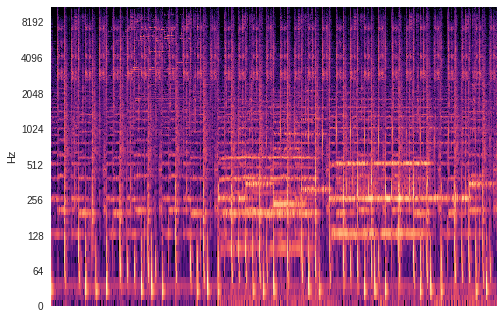

In [68]:
# Hyper parameters.
seed            = 42
hidden_size     = 256
number_layers   = 2
sequence_length = 10
learning_rate   = 0.001
batch_size      = 512
number_epochs   = 100
fft_size        = 1024

display         = True

url = 'http://www.jewelbeat.com/free/free-music/JewelBeat%20-%20Haunted%20Revenge.wav'
# url = 'http://doc.gold.ac.uk/~lfedd001/eno4.wav'

feature_size = input_size = (fft_size // 2) + 1
hop_length = fft_size // 4

# Construct RNN, loss function and optimiser.
rnn = RNN(input_size, hidden_size, number_layers, feature_size)
criterion = nn.MSELoss()

if torch.cuda.is_available():
  rnn.cuda()
  criterion.cuda()
  torch.cuda.manual_seed(seed)
else:
  torch.manual_seed(seed)
  
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

dataset = AudioDataset(url, fft_size, hop_length)

# Plot and listen to the audio.
if display:
  plot_audio(dataset.data) 
  

In [0]:
if display:
  IPython.display.Audio(dataset.data, rate=dataset.sample_rate)

In [70]:
train(rnn, 
      criterion,
      optimiser,
      dataset,
      sequence_length, 
      batch_size, 
      number_epochs, 
      fft_size, 
      hop_length)

Epoch 1/100, Loss 15.621316909790039
Epoch 1/100, Loss 15.769702911376953
Epoch 1/100, Loss 15.439844131469727
Epoch 1/100, Loss 12.799309730529785
Epoch 1/100, Loss 13.714499473571777
Epoch 1/100, Loss 13.876246452331543
Epoch 1/100, Loss 12.233004570007324
Epoch 2/100, Loss 15.286808967590332
Epoch 2/100, Loss 12.555459022521973
Epoch 2/100, Loss 12.039421081542969
Epoch 2/100, Loss 11.867968559265137
Epoch 2/100, Loss 12.029862403869629
Epoch 2/100, Loss 13.250654220581055
Epoch 2/100, Loss 11.606553077697754
Epoch 3/100, Loss 10.955166816711426
Epoch 3/100, Loss 11.307083129882812
Epoch 3/100, Loss 11.456521034240723
Epoch 3/100, Loss 10.715843200683594
Epoch 3/100, Loss 12.552531242370605
Epoch 3/100, Loss 12.873942375183105
Epoch 3/100, Loss 12.1996488571167
Epoch 4/100, Loss 10.310232162475586
Epoch 4/100, Loss 8.986581802368164
Epoch 4/100, Loss 13.11022663116455
Epoch 4/100, Loss 12.719643592834473
Epoch 4/100, Loss 11.77003288269043
Epoch 4/100, Loss 10.206724166870117
Epoch 

Epoch 27/100, Loss 6.364501953125
Epoch 27/100, Loss 7.471647262573242
Epoch 28/100, Loss 6.424892902374268
Epoch 28/100, Loss 7.387340545654297
Epoch 28/100, Loss 6.177886486053467
Epoch 28/100, Loss 5.753908634185791
Epoch 28/100, Loss 6.217387676239014
Epoch 28/100, Loss 6.158727645874023
Epoch 28/100, Loss 6.481983661651611
Epoch 29/100, Loss 6.6560750007629395
Epoch 29/100, Loss 6.610275745391846
Epoch 29/100, Loss 5.890382766723633
Epoch 29/100, Loss 5.443985939025879
Epoch 29/100, Loss 6.8230671882629395
Epoch 29/100, Loss 6.581551551818848
Epoch 29/100, Loss 6.22690486907959
Epoch 30/100, Loss 6.209561824798584
Epoch 30/100, Loss 7.099230766296387
Epoch 30/100, Loss 6.261946678161621
Epoch 30/100, Loss 5.146160125732422
Epoch 30/100, Loss 6.082100868225098
Epoch 30/100, Loss 6.160310745239258
Epoch 30/100, Loss 6.3209614753723145
Epoch 31/100, Loss 5.790166854858398
Epoch 31/100, Loss 6.194579601287842
Epoch 31/100, Loss 6.683713912963867
Epoch 31/100, Loss 6.028561592102051
Ep

Epoch 54/100, Loss 4.334070682525635
Epoch 54/100, Loss 3.9727602005004883
Epoch 54/100, Loss 4.567380905151367
Epoch 55/100, Loss 3.475404739379883
Epoch 55/100, Loss 4.6586012840271
Epoch 55/100, Loss 4.382935523986816
Epoch 55/100, Loss 5.019075393676758
Epoch 55/100, Loss 3.537161111831665
Epoch 55/100, Loss 4.656251430511475
Epoch 55/100, Loss 4.496262550354004
Epoch 56/100, Loss 4.348691940307617
Epoch 56/100, Loss 4.0451340675354
Epoch 56/100, Loss 4.508164882659912
Epoch 56/100, Loss 4.515663146972656
Epoch 56/100, Loss 4.614799499511719
Epoch 56/100, Loss 3.8177995681762695
Epoch 56/100, Loss 3.5404553413391113
Epoch 57/100, Loss 4.284971237182617
Epoch 57/100, Loss 4.46929407119751
Epoch 57/100, Loss 3.5584523677825928
Epoch 57/100, Loss 3.897690773010254
Epoch 57/100, Loss 4.427809715270996
Epoch 57/100, Loss 4.455080032348633
Epoch 57/100, Loss 3.868698835372925
Epoch 58/100, Loss 4.128266334533691
Epoch 58/100, Loss 3.368135690689087
Epoch 58/100, Loss 4.426870822906494
Ep

Epoch 81/100, Loss 3.0725977420806885
Epoch 81/100, Loss 2.856618881225586
Epoch 81/100, Loss 3.2365190982818604
Epoch 81/100, Loss 3.173292875289917
Epoch 81/100, Loss 2.947216033935547
Epoch 82/100, Loss 2.6892762184143066
Epoch 82/100, Loss 2.743492364883423
Epoch 82/100, Loss 3.1653876304626465
Epoch 82/100, Loss 2.976712465286255
Epoch 82/100, Loss 2.985665798187256
Epoch 82/100, Loss 3.2873504161834717
Epoch 82/100, Loss 3.0341551303863525
Epoch 83/100, Loss 2.946922540664673
Epoch 83/100, Loss 3.399675130844116
Epoch 83/100, Loss 2.988328218460083
Epoch 83/100, Loss 2.947845697402954
Epoch 83/100, Loss 1.9859552383422852
Epoch 83/100, Loss 3.292788028717041
Epoch 83/100, Loss 2.912051200866699
Epoch 84/100, Loss 2.510850429534912
Epoch 84/100, Loss 3.472283124923706
Epoch 84/100, Loss 3.3151350021362305
Epoch 84/100, Loss 2.738919258117676
Epoch 84/100, Loss 2.7538044452667236
Epoch 84/100, Loss 2.7962687015533447
Epoch 84/100, Loss 2.539180040359497
Epoch 85/100, Loss 2.6301696

/usr/local/lib/python3.6/dist-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/usr/local/lib/python3.6/dist-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


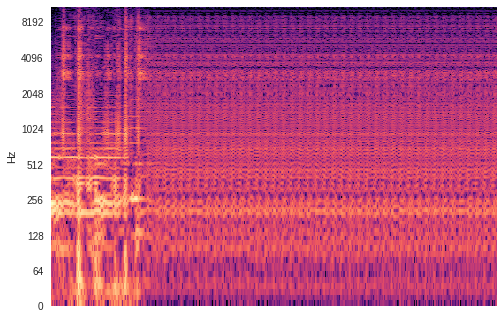

In [71]:
magnitudes = run(rnn, dataset, sequence_length, 1000)
predicted_audio = griffin_lim(magnitudes.T, 
                              n_iter=100, 
                              window='hann', 
                              n_fft=fft_size, 
                              hop_length=hop_length)

plot_audio(predicted_audio) 
IPython.display.Audio(predicted_audio, rate=dataset.sample_rate)

In [0]:
from google.colab import files
from datetime import datetime
import json

hyper_params = {}
hyper_params['seed']            = seed
hyper_params['hidden_size']     = hidden_size
hyper_params['number_layers']   = number_layers
hyper_params['sequence_length'] = sequence_length
hyper_params['learning_rate']   = learning_rate
hyper_params['batch_size']      = batch_size
hyper_params['number_epochs']   = number_epochs
hyper_params['fft_size']        = fft_size
hyper_params['url']             = url 
hyper_params['feature_size']    = feature_size
hyper_params['hop_length']      = hop_length

file_name = datetime.utcnow().strftime('%Y_%m_%d_%H_%M_%S_%f')[:-3]

with open(file_name + '.json', 'w') as f:
  json.dump(hyper_params, f, sort_keys=True, indent=4)
librosa.output.write_wav(file_name + "_original.wav", dataset.data, dataset.sample_rate)
librosa.output.write_wav(file_name + "_predicted.wav", predicted_audio, dataset.sample_rate)


files.download(file_name + "_original.wav")
files.download(file_name + "_predicted.wav")
files.download(file_name + '.json')